This notebook computes the learning outcomes from the pre-test and post-test responses.

We consider two learning goals:
* LG1: identify a (feasible) solution to the problem
* LG2: construct a correct (i.e. optimal) solution.
    
For LG1, we check connectedness, i.e. if solutions are spanning or not
out.

For LG2, we check optimality, i.e. how close was the solution to the correct solution, quantified by the error.

In [1]:
import math
import copy
import pickle

import pathlib as pl
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import wilcoxon, shapiro, ttest_rel
from effsize.effsize import two_group_difference

from utils import plot_comparison

In [2]:
# Visuals in paper theme, with larger font and thicker lines.
sns.set_theme()
sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 2.5})

### Define paths.

In [3]:
# Inputs.
transitions_pickle_file = pl.Path(
    '../processed_data/justhink21_transitions.pickle')

# Outputs.
learning_file = pl.Path(
    '../processed_data/justhink21_learning_outcomes.csv')
all_submissions_file = pl.Path(
    '../processed_data/justhink21_submissions.csv')
submissions_pickle_file = pl.Path(
    '../processed_data/justhink21_submissions.pickle')

figs_dir = pl.Path('../figures')

# Create the output figures directory if it does not exist.
figs_dir.mkdir(exist_ok=True)

In [4]:
# Number of items i.e. questions in a test.
test_item_counts = {
    'pretest': 5,
    'posttest': 5,
}

### Load transition tables.

In [5]:
with transitions_pickle_file.open('rb') as handle:
    transitions = pickle.load(handle)

<!-- ### Cleaning tables. -->

### Filter for the submissions.

In [6]:
def filter_submissions(transitions, verbose=False):
    """Get the submission states only, and drop the duplicates, 
    unused columns, keep state, activity, imported info."""
    tables = {}

    for participant in sorted(transitions):
        print('Filtering submissions for {}...'.format(participant))

        df = transitions[participant].copy()

        # Filter for the submission rows.
        df = df[df['is_submission']]

        # Remove duplicate rows from submission log and keeping the last submission.
        df.drop_duplicates(
            subset=['activity', 'attempt_no'], keep='last', inplace=True)

        tables[participant] = df

        if verbose:
            display(df)

    print('Done!')

    return tables


submissions = filter_submissions(transitions)

# Sneak peek:
# submissions[8]

Filtering submissions for 1...
Filtering submissions for 2...
Filtering submissions for 3...
Filtering submissions for 4...
Filtering submissions for 5...
Filtering submissions for 6...
Filtering submissions for 7...
Filtering submissions for 8...
Filtering submissions for 9...
Done!


### Count feasible and optimal solutions in the tests.

In [7]:
def count_feasible(df, test_name, total_count):
    """Count the number of feasible solutions given to a 
    pre-test or post-test."""
    count = 0
    feas_count = 0
    for index, row in df.iterrows():
        if test_name in row['activity']:
            count = count + 1
            if row['is_spanning']:
                feas_count = feas_count + 1

    # Validity check.
    if count != total_count:
        print('Log of {} does not match with the number of items in {}'.format(
            participant, test_name))
        print(count, total_count)
        raise ValueError

    return feas_count


def score_feasible(df, test_name, total_count):
    return count_feasible(df, test_name, total_count) / total_count


for participant, df in submissions.items():
    print('{:2.0f}: feasible scores: pre-test {}, post-test {}'.format(
        participant,
        score_feasible(df, 'pretest', test_item_counts['pretest']),
        score_feasible(df, 'posttest', test_item_counts['posttest'])))

 1: feasible scores: pre-test 1.0, post-test 1.0
 2: feasible scores: pre-test 0.8, post-test 1.0
 3: feasible scores: pre-test 1.0, post-test 1.0
 4: feasible scores: pre-test 0.8, post-test 1.0
 5: feasible scores: pre-test 1.0, post-test 0.8
 6: feasible scores: pre-test 1.0, post-test 0.8
 7: feasible scores: pre-test 0.4, post-test 0.0
 8: feasible scores: pre-test 1.0, post-test 1.0
 9: feasible scores: pre-test 1.0, post-test 1.0


In [8]:
def count_optimal(df, test_name, total_count):
    """Count the number of optimal solutions given to a 
    pre-test or post-test."""
    count = 0
    opt_count = 0
    for index, row in df.iterrows():
        if test_name in row['activity']:
            count = count + 1
            if row['is_mst']:
                opt_count = opt_count + 1

    # Validity check.
    if count != total_count:
        print('Log of {} does not match with the number of items in {}'.format(
            participant, test_name))
        print(count, total_count)
        raise ValueError

    return opt_count


def score_optimal(df, test_name, total_count):
    return count_optimal(df, test_name, total_count) / total_count


for participant, df in submissions.items():
    print('{:2.0f}: optimal scores: pre-test {}, post-test {}'.format(
        participant,
        score_optimal(df, 'pretest', test_item_counts['pretest']),
        score_optimal(df, 'posttest', test_item_counts['posttest'])))

 1: optimal scores: pre-test 0.4, post-test 0.8
 2: optimal scores: pre-test 0.0, post-test 0.8
 3: optimal scores: pre-test 0.2, post-test 1.0
 4: optimal scores: pre-test 0.0, post-test 0.0
 5: optimal scores: pre-test 0.0, post-test 0.0
 6: optimal scores: pre-test 0.0, post-test 0.0
 7: optimal scores: pre-test 0.2, post-test 0.0
 8: optimal scores: pre-test 0.0, post-test 0.0
 9: optimal scores: pre-test 0.8, post-test 0.8


### Compute average error in the tests.

In [9]:
def compute_average_error(df, test_name, total_count):
    """Compute average error for a test."""
    total_error = 0
    count = 0
    valid_count = 0
    for index, row in df.iterrows():
        error = row['error']
        if test_name in row['activity']:
            count = count + 1
            # Not computing the error for submissions that are not feasible/spanning.
            if not math.isnan(error):
                valid_count = valid_count + 1
                total_error = total_error + error

    # Validity check.
    if count != total_count:
        print('Log of {} does not match with the number of items in {}'.format(
            participant, test_name))
        print(count, total_count)
        raise ValueError

    # Compute average, handling if no valid responses.
    if valid_count > 0:
        average_error = total_error / total_count
    else:
        average_error = None
    return average_error


for participant, df in submissions.items():
    print('{:2.0f}: average errors: pre-test {}, post-test {}'.format(
        participant,
        compute_average_error(df, 'pretest', test_item_counts['pretest']),
        compute_average_error(df, 'posttest', test_item_counts['posttest'])))

 1: average errors: pre-test 0.16952380952380955, post-test 0.013333333333333332
 2: average errors: pre-test 0.31047619047619046, post-test 0.009523809523809523
 3: average errors: pre-test 0.040634920634920635, post-test 0.0
 4: average errors: pre-test 0.3898412698412698, post-test 0.3555555555555555
 5: average errors: pre-test 0.3003174603174603, post-test 0.16698412698412696
 6: average errors: pre-test 0.30984126984126986, post-test 0.14984126984126983
 7: average errors: pre-test 0.04, post-test None
 8: average errors: pre-test 0.9257142857142858, post-test 0.1034920634920635
 9: average errors: pre-test 0.013333333333333332, post-test 0.009523809523809523


### Make a learning outcomes table.

In [10]:
participants = sorted(submissions.keys())
tests = ['pretest', 'posttest']

learning_df = pd.DataFrame(index=participants)
learning_df.index.name = 'participant'
for test in tests:
    count = test_item_counts[test]
    learning_df['{}_feasible'.format(test)] = \
        [score_feasible(submissions[p], test, count)
         for p in learning_df.index]

for test in tests:
    count = test_item_counts[test]
    learning_df['{}_optimal'.format(test)] = \
        [score_optimal(submissions[p], test, count)
         for p in learning_df.index]

for test in tests:
    count = test_item_counts[test]
    learning_df['{}_error'.format(test)] = \
        [compute_average_error(submissions[p], test, count)
         for p in learning_df.index]

learning_df

,pretest_feasible,posttest_feasible,pretest_optimal,posttest_optimal,pretest_error,posttest_error
participant,,,,,,
1,1.0,1.0,0.4,0.8,0.169524,0.013333
2,0.8,1.0,0.0,0.8,0.310476,0.009524
3,1.0,1.0,0.2,1.0,0.040635,0.000000
4,0.8,1.0,0.0,0.0,0.389841,0.355556
5,1.0,0.8,0.0,0.0,0.300317,0.166984
6,1.0,0.8,0.0,0.0,0.309841,0.149841
7,0.4,0.0,0.2,0.0,0.040000,NaN
8,1.0,1.0,0.0,0.0,0.925714,0.103492
9,1.0,1.0,0.8,0.8,0.013333,0.009524


### Visualize feasible solutions in the tests.

In [11]:
test_xvalues = ['pre-test', 'post-test']

7 (0.4, 0.0) 0.4 0.0
1 (1.0, 1.0) 1.0 1.0
3 (1.0, 1.0) 0.99 0.99
8 (1.0, 1.0) 0.98 0.98
9 (1.0, 1.0) 0.97 0.97
2 (0.8, 1.0) 0.8 0.96
4 (0.8, 1.0) 0.79 0.95
5 (1.0, 0.8) 0.96 0.8
6 (1.0, 0.8) 0.95 0.79
../figures/learning_outcomes_is_feasible.pdf


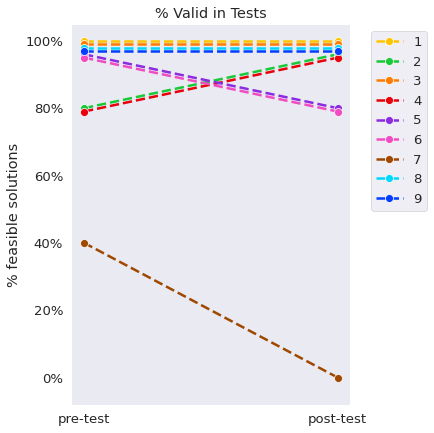

In [12]:
def plot_feasible(learning_df, ax=None, save=True, verbose=False):
    # Order participants to have aligned offsets of repeating values.
    participants = [7, 1, 3, 8, 9, 2, 4, 5, 6]

    # Define function to retrieve and plot the feasible scores.
    def get_values_from_row(row):
        return (row.pretest_feasible, row.posttest_feasible)

    # Plot the changes from pre-test to post-test.
    export_file = figs_dir.joinpath('learning_outcomes_is_feasible.pdf')
    plot_comparison(
        learning_df, participants=participants, xvalues=test_xvalues,
        ylabel='% feasible solutions', title='% Valid in Tests',
        export_file=export_file,  getter=get_values_from_row,
        ax=ax, save=save, verbose=verbose)


plot_feasible(learning_df, verbose=True)

### Visualize optimal solutions by count in the tests.

../figures/learning_outcomes_is_optimal.pdf


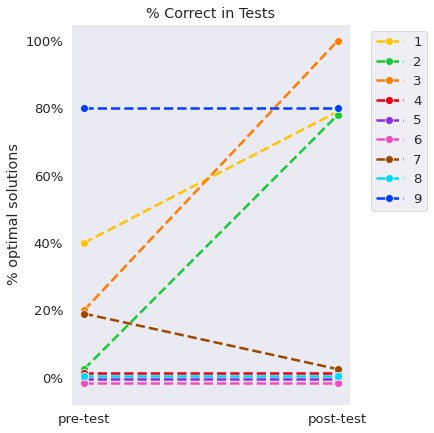

In [13]:
def plot_optimal(learning_df, ax=None, save=True, verbose=False):
    # Order participants to have aligned offsets of repeating values.
    participants = [9, 1, 2, 3, 7, 4, 8, 5, 6]

    # Define function to retrieve and plot the optimal scores.
    def get_values_from_row(row):
        return (row.pretest_optimal, row.posttest_optimal)

    # Plot the changes from pre-test to post-test.
    export_file = figs_dir.joinpath('learning_outcomes_is_optimal.pdf')
    plot_comparison(
        learning_df, participants=participants, xvalues=test_xvalues,
        ylabel='% optimal solutions', title='% Correct in Tests',
        export_file=export_file, getter=get_values_from_row, ax=ax,
        save=save, zero_offset=+0.025)


plot_optimal(learning_df, verbose=True)

### Visualize optimal solutions by error in the tests.

In [14]:
# Define function to retrieve and plot the average errors.
def get_values_from_row(row):
    return (row.pretest_error, row.posttest_error)

row = learning_df.loc[7]
position = get_values_from_row(row)
position
math.isnan(position[0]) or math.isnan(position[0])

False

2 (0.31047619047619046, 0.009523809523809523) 0.31047619047619046 0.009523809523809523
6 (0.30984126984126986, 0.14984126984126983) 0.30984126984126986 0.14984126984126983
5 (0.3003174603174603, 0.16698412698412696) 0.3003174603174603 0.16698412698412696
7 (0.04, nan) 0.04 nan
4 (0.3898412698412698, 0.3555555555555555) 0.3898412698412698 0.3555555555555555
8 (0.9257142857142858, 0.1034920634920635) 0.9257142857142858 0.1034920634920635
3 (0.040634920634920635, 0.0) 0.040634920634920635 0.0
9 (0.013333333333333332, 0.009523809523809523) 0.013333333333333332 0.009523809523809523
1 (0.16952380952380955, 0.013333333333333332) 0.16952380952380955 0.013333333333333332
../figures/learning_outcomes_error.pdf


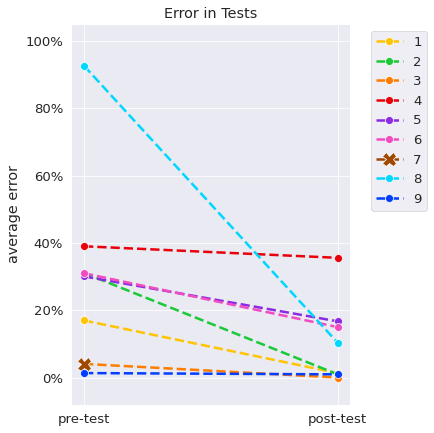

In [15]:
def plot_error(learning_df, ax=None, save=True, verbose=False):
    # Order participants to have aligned offsets of repeating values.
    participants = [2, 6, 5, 7, 4, 8, 3, 9, 1]

    # Define function to retrieve and plot the average errors.
    def get_values_from_row(row):
        return (row.pretest_error, row.posttest_error)

    # Plot the changes from pre-test to post-test.
    export_file = figs_dir.joinpath('learning_outcomes_error.pdf')
    plot_comparison(
        learning_df, participants=participants,
        ylabel='average error', title='Error in Tests',
        xvalues=test_xvalues, export_file=export_file,
        yticks=True, offset=0, ygrid=True, verbose=verbose,
        getter=get_values_from_row, ax=ax, save=save)


plot_error(learning_df, verbose=True)

### Visualize all in one figure.

../figures/learning_outcomes.pdf


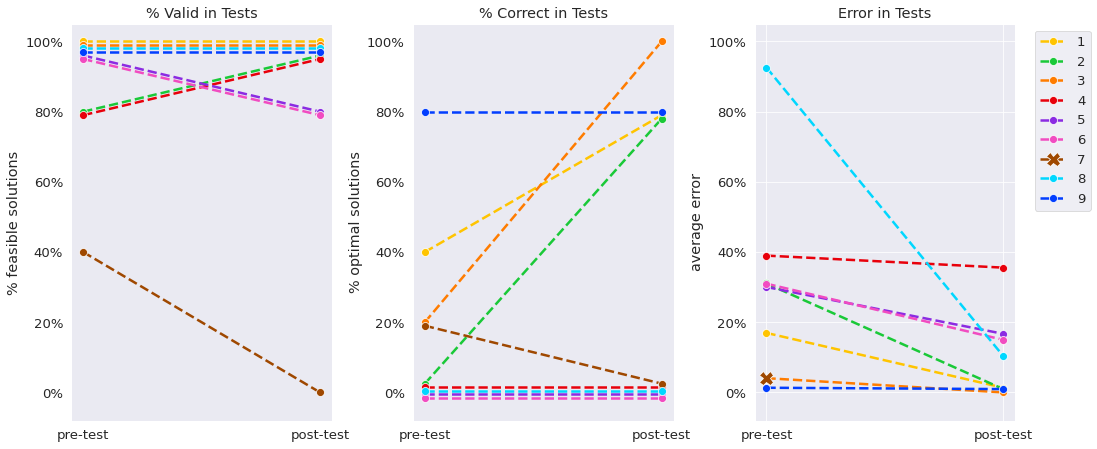

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

plot_feasible(learning_df, ax=axes[0], save=False)
plot_optimal(learning_df, ax=axes[1], save=False)
plot_error(learning_df, ax=axes[2], save=False)

fig.tight_layout(pad=-0.1)
export_file = figs_dir.joinpath('learning_outcomes.pdf')
plt.savefig(export_file, bbox_inches='tight')

print(export_file)

### Perform Wilcoxon signed-rank test and compute the effect size (estimated by Cliff's delta).

In [17]:
learning_df

,pretest_feasible,posttest_feasible,pretest_optimal,posttest_optimal,pretest_error,posttest_error
participant,,,,,,
1,1.0,1.0,0.4,0.8,0.169524,0.013333
2,0.8,1.0,0.0,0.8,0.310476,0.009524
3,1.0,1.0,0.2,1.0,0.040635,0.000000
4,0.8,1.0,0.0,0.0,0.389841,0.355556
5,1.0,0.8,0.0,0.0,0.300317,0.166984
6,1.0,0.8,0.0,0.0,0.309841,0.149841
7,0.4,0.0,0.2,0.0,0.040000,NaN
8,1.0,1.0,0.0,0.0,0.925714,0.103492
9,1.0,1.0,0.8,0.8,0.013333,0.009524


In [18]:
# categories = ['feasible', 'optimal', 'error']
categories = ['error']

df = learning_df.dropna().copy()

for category in categories:
    
    r = list(df['pretest_{}'.format(category)])
    o = list(df['posttest_{}'.format(category)])

    print(category)
    print('r:', ['{:.3f}'.format(val) for val in r])
    print('o:', ['{:.3f}'.format(val) for val in o])
    
    print('Shapiro:')
    print('r:', shapiro(r))
    print('o:', shapiro(o))
          
    # # Can not do t-test: assumption for normality are not held.
    # t, p = ttest_rel(r, o)
    # print('Exact: t={}, p={}'.format(t, p))
    
    w, p = wilcoxon(r, o, mode='exact')
    
    # Null hypothesis says they are the same:
    # if p val less than threshold, reject hypothesis and
    # conclude that post and pre are different.
    print('Exact: W={}, p={}'.format(w, p))
    
    # a, b = wilcoxon(r, o, mode="exact", alternative="greater")
    # print('Greater: W={}, p={}'.format(a, b))

    # Estimate effect size by Cliff's Delta.
    d = two_group_difference(control=r, test=o, effect_size='cliffs_delta')
    print("Cliff's delta = {}".format(d))

error
r: ['0.170', '0.310', '0.041', '0.390', '0.300', '0.310', '0.926', '0.013']
o: ['0.013', '0.010', '0.000', '0.356', '0.167', '0.150', '0.103', '0.010']
Shapiro:
r: ShapiroResult(statistic=0.8358798623085022, pvalue=0.0683099776506424)
o: ShapiroResult(statistic=0.817490816116333, pvalue=0.043910637497901917)
Exact: W=0.0, p=0.0078125
Cliff's delta = -0.609375


### Merge the submission tables.

In [19]:
table_list = list()
for participant in sorted(submissions):
    df = submissions[participant].copy()
    table_list.append(df)
    
all_submissions_df = pd.concat(table_list)
all_submissions_df.reset_index(drop=True, inplace=True)
all_submissions_df.drop(columns=['is_submission'], inplace=True)

all_submissions_df.head()

,participant,time,activity,state,next_state,action,attempt_no,cost,opt_cost,error,is_mst,is_spanning
0,1,161.277439,pretest-1,"EnvironmentState(NetworkState(e:7+0,c:23|n:7,e...","EnvironmentState(NetworkState(e:7+0,c:23|n:7,e...","Action(submit,Human)",1,23,15,0.533333,False,True
1,1,251.009743,pretest-2,"EnvironmentState(NetworkState(e:7+0,c:38|n:7,e...","EnvironmentState(NetworkState(e:7+0,c:38|n:7,e...","Action(submit,Human)",1,38,30,0.266667,False,True
2,1,319.224974,pretest-3,"EnvironmentState(NetworkState(e:6+0,c:22|n:7,e...","EnvironmentState(NetworkState(e:6+0,c:22|n:7,e...","Action(submit,Human)",1,22,21,0.047619,False,True
3,1,386.282414,pretest-4,"EnvironmentState(NetworkState(e:6+0,c:45|n:7,e...","EnvironmentState(NetworkState(e:6+0,c:45|n:7,e...","Action(submit,Human)",1,45,45,0.000000,True,True
4,1,435.368411,pretest-5,"EnvironmentState(NetworkState(e:6+0,c:15|n:7,e...","EnvironmentState(NetworkState(e:6+0,c:15|n:7,e...","Action(submit,Human)",1,15,15,0.000000,True,True


### Add the merged table to the submission tables.

In [20]:
submissions['all'] = all_submissions_df

### Export the submissions tables in pickle format.

In [21]:
with submissions_pickle_file.open('wb') as handle:
    pickle.dump(submissions, handle, protocol=pickle.HIGHEST_PROTOCOL)

print('Saved the submission tables to {}'.format(submissions_pickle_file))

Saved the submission tables to ../processed_data/justhink21_submissions.pickle


### Export the merged submissions table in CSV data format.

In [22]:
all_submissions_df.to_csv(all_submissions_file, index=False)
print('Saved all submissions table to {}'.format(all_submissions_file))

Saved all submissions table to ../processed_data/justhink21_submissions.csv


### Export the learning outcomes table in CSV data format.

In [23]:
learning_df.to_csv(learning_file)
print('Saved learning outcomes table to {}'.format(learning_file))

Saved learning outcomes table to ../processed_data/justhink21_learning_outcomes.csv
